# Техническое задание

Автор: Кузьмин Дмитрий

## Задание

Анализ паттернов плохо распознаваемых EEG-файлов:

* Анализ качества сырых данных
* Анализ распределения признаков
* Анализ баланса классов
* Визуальный анализ EEG
* Анализ предсказаний модели

## Ожидаемые результаты

* Таблица QC-метрик для всех файлов проблемных пациентов
* Таблица баланса классов для всех пациентов
* Графики распределений признаков 
* ROC-кривые для проблемных пацфиентов
* Визуализации EEG — примеры preictal окон

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import mne
import seaborn as sns
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

## Анализ качества сырых данных

Цель: Выявить проблемы с качеством исходных EEG-записей.

In [2]:
problem_patient = ['chb15', 'chb18', 'chb19']
base_dir = r"C:\Users\_\Desktop\IT\epilepsy\outputs"
tables = []

for edf_file in sorted(os.listdir(base_dir)):
    folder_path = os.path.join(base_dir, edf_file)
    if not os.path.isdir(folder_path):
        continue
    qc_path = os.path.join(folder_path, "qc_results.csv")
    data = pd.read_csv(qc_path)
    if data['patient'].isin(problem_patient).any():
        continue
    tables.append(data)

qc_normal_patient = pd.concat(tables, ignore_index=True)
qc_normal_patient.to_csv("qc_normal_patient.csv", index=False)

In [3]:
qc_normal_patient[['nan_ratio', 'flat_ratio', 'clipped_ratio', 'mean_amplitude', 'max_amplitude']].describe()

,nan_ratio,flat_ratio,clipped_ratio,mean_amplitude,max_amplitude
count,570.0,570.000000,570.0,570.000000,570.000000
mean,0.0,0.000786,0.0,0.000035,0.001480
std,0.0,0.010886,0.0,0.000017,0.000540
min,0.0,0.000000,0.0,0.000008,0.000333
25%,0.0,0.000000,0.0,0.000024,0.001109
50%,0.0,0.000000,0.0,0.000031,0.001443
75%,0.0,0.000000,0.0,0.000043,0.001743
max,0.0,0.172414,0.0,0.000162,0.003873


In [4]:
qc_normal_patient

,patient,edf_file,edf_path,sampling_rate,n_channels,n_samples,is_good,nan_ratio,flat_ratio,flat_channels,clipped_ratio,mean_amplitude,max_amplitude
0,chb01,chb01_01.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001038
1,chb01,chb01_02.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000021,0.001388
2,chb01,chb01_03.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000031,0.000595
3,chb01,chb01_04.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001286
4,chb01,chb01_05.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001386
...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,chb24,chb24_13.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001118
566,chb24,chb24_14.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000028,0.001254
567,chb24,chb24_15.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001312
568,chb24,chb24_17.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000039,0.001504


In [5]:
chb15 = pd.read_csv(r'C:\Users\_\Desktop\IT\epilepsy\outputs\chb15\qc_results.csv')
chb18 = pd.read_csv(r'C:\Users\_\Desktop\IT\epilepsy\outputs\chb18\qc_results.csv')
chb19 = pd.read_csv(r'C:\Users\_\Desktop\IT\epilepsy\outputs\chb19\qc_results.csv')

qc_problem_patient = pd.concat([chb15, chb18, chb19], ignore_index=True)
qc_problem_patient.to_csv("qc_problem_patient.csv", index=False)

In [6]:
qc_problem_patient[['nan_ratio', 'flat_ratio', 'clipped_ratio', 'mean_amplitude', 'max_amplitude']].describe()

,nan_ratio,flat_ratio,clipped_ratio,mean_amplitude,max_amplitude
count,106.0,106.0,106.0,106.000000,106.000000
mean,0.0,0.0,0.0,0.000015,0.001214
std,0.0,0.0,0.0,0.000006,0.000709
min,0.0,0.0,0.0,0.000009,0.000355
25%,0.0,0.0,0.0,0.000012,0.000742
50%,0.0,0.0,0.0,0.000015,0.001007
75%,0.0,0.0,0.0,0.000017,0.001485
max,0.0,0.0,0.0,0.000058,0.005549


In [7]:
qc_normal_patient['group'] = 'Normal'
qc_problem_patient['group'] = 'Problem'

In [8]:
QC_data = pd.concat([qc_normal_patient, qc_problem_patient], ignore_index=True)
QC_data

,patient,edf_file,edf_path,sampling_rate,n_channels,n_samples,is_good,nan_ratio,flat_ratio,flat_channels,clipped_ratio,mean_amplitude,max_amplitude,group
0,chb01,chb01_01.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001038,Normal
1,chb01,chb01_02.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000021,0.001388,Normal
2,chb01,chb01_03.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000031,0.000595,Normal
3,chb01,chb01_04.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001286,Normal
4,chb01,chb01_05.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001386,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,chb19,chb19_26.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000015,0.001581,Problem
672,chb19,chb19_27.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000022,0.001159,Problem
673,chb19,chb19_28.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,924672,True,0.0,0.0,[],0.0,0.000032,0.002495,Problem
674,chb19,chb19_29.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000027,0.002391,Problem


In [9]:
file_index = pd.read_csv(r'C:\Users\_\Desktop\IT\epilepsy\outputs\file_index.csv')
seizure_index = pd.read_csv(r'C:\Users\_\Desktop\IT\epilepsy\outputs\seizure_index.csv')

In [10]:
seizure_columns = seizure_index.columns.difference(['patient', 'edf_path', 'sampling_rate'])

files_data = pd.merge(
    file_index, 
    seizure_index[seizure_columns], 
    on='edf_file', 
    how='left'
)

files_data = files_data[files_data['num_seizures'] >= 1]

In [11]:
files_data = files_data.drop(['file_end_time', 'file_start_time', 'seizure_id', 'seizures', 'file_exists'], axis=1)

In [12]:
files_data = files_data[['patient', 'edf_file', 'num_seizures', 'start_time', 'end_time', 'onset_sec', 'offset_sec', 'duration_sec', 'sampling_rate', 'channels']]
files_data

,patient,edf_file,num_seizures,start_time,end_time,onset_sec,offset_sec,duration_sec,sampling_rate,channels
2,chb01,chb01_03.edf,1,13:43:04,14:43:04,2996.0,3036.0,40.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
3,chb01,chb01_04.edf,1,14:43:12,15:43:12,1467.0,1494.0,27.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
14,chb01,chb01_15.edf,1,01:44:44,2:44:44,1732.0,1772.0,40.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
15,chb01,chb01_16.edf,1,02:44:51,3:44:51,1015.0,1066.0,51.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
17,chb01,chb01_18.edf,1,04:45:06,5:45:06,1720.0,1810.0,90.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
...,...,...,...,...,...,...,...,...,...,...
728,chb24,chb24_13.edf,1,NaN,NaN,3288.0,3304.0,16.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
729,chb24,chb24_14.edf,1,NaN,NaN,1939.0,1966.0,27.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
730,chb24,chb24_15.edf,1,NaN,NaN,3552.0,3569.0,17.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."
731,chb24,chb24_17.edf,1,NaN,NaN,3515.0,3581.0,66.0,256,"['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3'..."


In [13]:
QC_data

,patient,edf_file,edf_path,sampling_rate,n_channels,n_samples,is_good,nan_ratio,flat_ratio,flat_channels,clipped_ratio,mean_amplitude,max_amplitude,group
0,chb01,chb01_01.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001038,Normal
1,chb01,chb01_02.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000021,0.001388,Normal
2,chb01,chb01_03.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000031,0.000595,Normal
3,chb01,chb01_04.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001286,Normal
4,chb01,chb01_05.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000023,0.001386,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,chb19,chb19_26.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000015,0.001581,Problem
672,chb19,chb19_27.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000022,0.001159,Problem
673,chb19,chb19_28.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,924672,True,0.0,0.0,[],0.0,0.000032,0.002495,Problem
674,chb19,chb19_29.edf,C:\Users\_\Desktop\IT\epilepsy\files\chbmit\1....,256,17,921600,True,0.0,0.0,[],0.0,0.000027,0.002391,Problem


In [14]:
data = pd.merge(
    file_index,  
    QC_data[['patient', 'edf_file', 'nan_ratio', 'flat_ratio', 'flat_channels', 
             'clipped_ratio', 'mean_amplitude', 'max_amplitude', 'group']],
    on=['patient','edf_file'],
    how='left'   
)
data = data.drop(['seizures', 'channels', 'file_exists', 'sampling_rate', 'edf_path'], axis=1)

In [15]:
data[['nan_ratio', 'flat_ratio', 'clipped_ratio', 'mean_amplitude', 'max_amplitude']].describe()

,nan_ratio,flat_ratio,clipped_ratio,mean_amplitude,max_amplitude
count,676.0,676.000000,676.0,676.000000,676.000000
mean,0.0,0.000663,0.0,0.000032,0.001439
std,0.0,0.009998,0.0,0.000017,0.000577
min,0.0,0.000000,0.0,0.000008,0.000333
25%,0.0,0.000000,0.0,0.000021,0.001015
50%,0.0,0.000000,0.0,0.000028,0.001373
75%,0.0,0.000000,0.0,0.000040,0.001719
max,0.0,0.172414,0.0,0.000162,0.005549


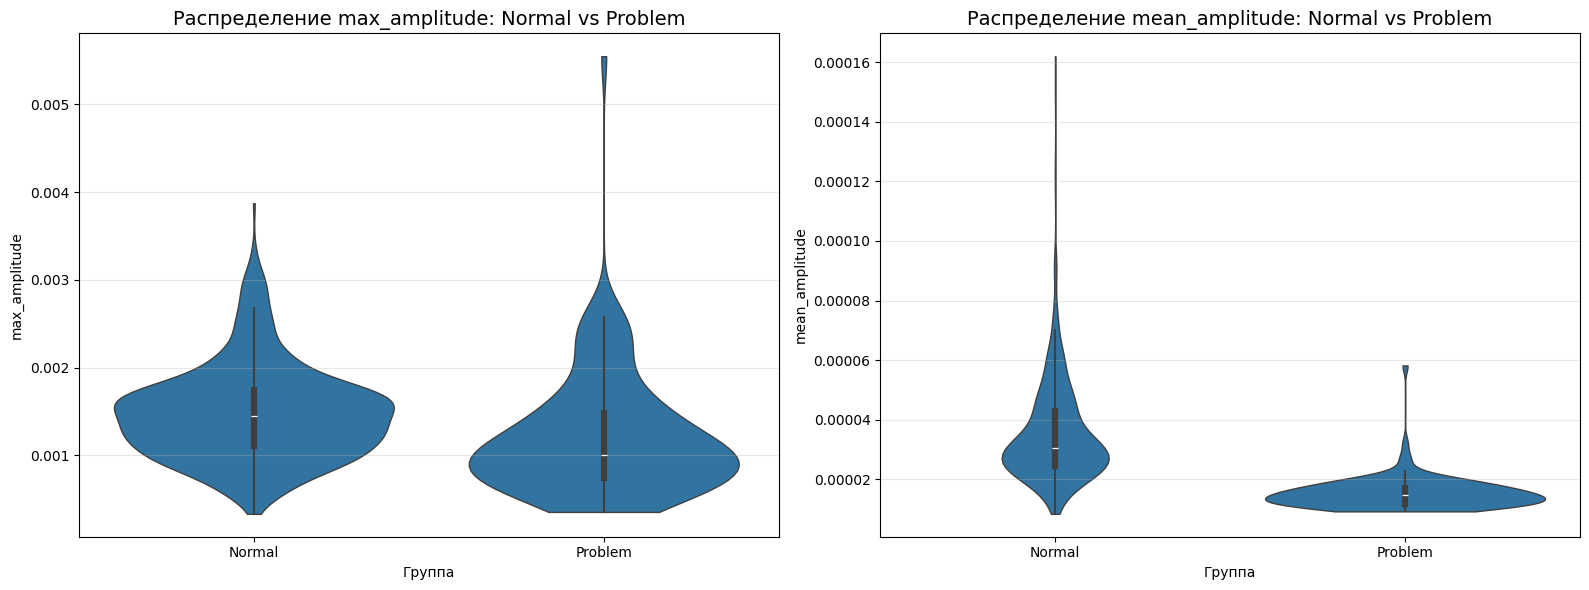

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.violinplot(
    data=data,
    x='group',
    y='max_amplitude',
    inner='box',
    cut=0,
    linewidth=1,
    ax=axes[0] 
)
axes[0].set_title('Распределение max_amplitude: Normal vs Problem', fontsize=14)
axes[0].set_xlabel('Группа')
axes[0].set_ylabel('max_amplitude')
axes[0].grid(axis='y', alpha=0.3)

sns.violinplot(
    data=data,
    x='group',
    y='mean_amplitude',
    inner='box',
    cut=0,
    linewidth=1,
    ax=axes[1] 
)
axes[1].set_title('Распределение mean_amplitude: Normal vs Problem', fontsize=14)
axes[1].set_xlabel('Группа')
axes[1].set_ylabel('mean_amplitude')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


теперь есть общий датафрейм с метриками, которые рассчитаны на две группы пользователей: нормальные и проблемные. в качестве проблемных мы рассматриваем группу: chb15, chb18, chb19

<Axes: xlabel='group', ylabel='max_amplitude'>

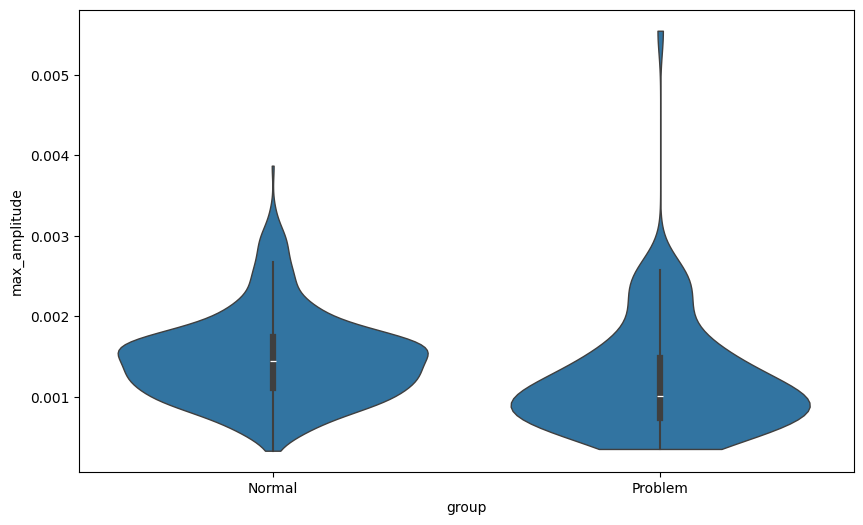

In [17]:
plt.figure(figsize=(10, 6))

sns.violinplot(
    data=data,
    x="group",
    y="max_amplitude",
    inner="box",   
    cut=0,        
    linewidth=1
)

NameError: name 'qc_table' is not defined

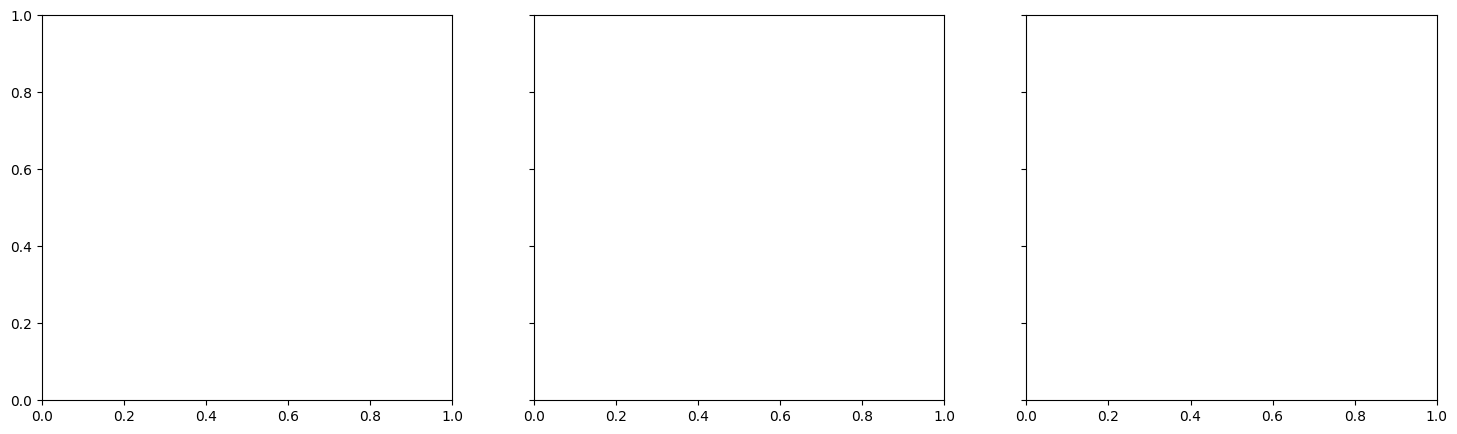

In [18]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for ax, patient in zip(axes, ['chb15', 'chb18', 'chb19']):
    subset = qc_table[qc_table['patient'] == patient]
    ax.hist(subset['max_amplitude'], bins=15, edgecolor='black')
    ax.set_title(f'{patient}: max_amplitude')
    ax.set_xlabel('max_amplitude')
axes[0].set_ylabel('Количество файлов')
plt.tight_layout()
plt.show()

## Анализ баланса классов

Цель: Проверить корректность разметки и баланс классов

Метрики: n_files, n_seizure_files, n_windows, n_preictal, n_interictal, ratio